# Colaboratoryで実行する場合
以下を実行して、外部ファイルをダウンロードしてください。   
**このセルはColaboratoryを起動するたびに必要となります**   
**<font color='red'>和文フォントをインストールしています。以下のセルを実行後、ランタイムをリスタートしてください。</font>**

In [ ]:
##################################
### Colaboratoryのみ以下を実行 ###
##################################
import sys
if 'google.colab' in sys.modules:
    !wget -P ./text http://www.hal.t.u-tokyo.ac.jp/~yamakata/lecture/mediaproc/mediaproc4/wiki_wakati.txt
    !mkdir model
    !mkdir fig
    # 以下は日本語フォントをインストールするコマンドです
    !apt-get -y install fonts-ipafont-gothic
    !rm /root/.cache/matplotlib/*.json

# トピック分析３：Word2vecによるWord Embedding

ニューラルネットワークによって単語をベクトル化するWord2vecを学びましょう。  
ここで、このベクトルとは、その単語の意味が近ければ近く、遠ければ遠くなるようなベクトルです。   
また、word2vecで生成されるこのベクトルは、加算・減算ができるということで大きな注目を集めました。   
以下のような例が有名です。
```
king - man + woman = queen
```
LDAと同じくgensimというライブラリを使って演習します。


## 1. モデル学習

いま、`text/wiki_wakati.txt`には、基礎演習で用いた6カテゴリからなる2101個のWikipedia記事の本文について、分かち書きされた文が保存されています。  
ここに含まれる語彙のそれぞれを`size`で指定されたサイズの次元のベクトルに変換しましょう。   
コーパスにあまり現れない単語まで学習しようとすると精度が低くなるので、
`mini_count`パラメータを設定して最低20回以上現れる単語に限りましょう。   
また、word2vecでは、ある単語の性質を、その前後の単語が何かによって特徴量化していくのですが、このときに考慮する周辺の単語数（窓幅）`window`は5単語とします。つまり、その単語より前の5単語と、後ろの5単語をもって、その単語の特徴とするということです。   
窓幅が広すぎると、文全体を学習することになって精度が落ちます。

以下のプログラムを実行すると、ピンクの背景で学習時のログが出力されます。   
たとえば

```
2020-06-12 13:20:54,586 : INFO : effective_min_count=20 retains 7668 unique words (11% of original 67458, drops 59790)
2020-06-12 13:20:54,588 : INFO : effective_min_count=20 leaves 2217791 word corpus (92% of original 2404119, drops 186328)
```
は、`mini_count`を20単語にしたことにより、語彙数は59790から7668に削減され、またそれに伴い文中の全2404119単語のうち、92％に相当する2217791単語が学習に使われたことを意味します。   
また、その後にEPOCHが1から5まで続いて出力されるでしょう。   
ニューラルネットワークでは、まず学習データとして入力ベクトルと出力ベクトルの対を大量に用意します。   
また、モデルのパラメータはランダムに設定されます。ですから初期のモデルはでたらめな答えを返すようなモデルです。   
学習のフェーズでは、この対を1つずつモデルに渡して、
入力ベクトルに対し、対応する出力ベクトルが出力されるようにモデルのパラメータを更新していきます。   
このとき、すべての学習データに対して一通りパラメータを更新すればそれで終わりではなく、
同じデータを何度も入力して繰り返し学習します。   
この各繰り返しをエポックと呼び、今回は全データを5回学習するように設定されています。

In [1]:
from gensim.models import word2vec
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
sentences = word2vec.Text8Corpus('text/wiki_wakati.txt')

model = word2vec.Word2Vec(sentences, # 入力文の集合
                        size=200, # 隠れ層の次元＝embedされた単語ベクトルの次元
                        min_count=20, # 出現回数が20単語以下のものは削除
                        batch_words=10000,# 全文書を10000単語ごとに分割して学習
                        iter = 5, # 全文書を学習する過程を何回繰り返すか(エポック数とも呼ぶ)
                        window=15) # 考慮する周辺単語数。ここでは前後5単語

model.save('model/wiki.model') # 学習済みモデルを保存しておきましょう

2020-06-24 21:08:35,996 : INFO : collecting all words and their counts
2020-06-24 21:08:36,002 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-06-24 21:08:37,329 : INFO : collected 67458 word types from a corpus of 2404119 raw words and 241 sentences
2020-06-24 21:08:37,330 : INFO : Loading a fresh vocabulary
2020-06-24 21:08:37,399 : INFO : effective_min_count=20 retains 7668 unique words (11% of original 67458, drops 59790)
2020-06-24 21:08:37,401 : INFO : effective_min_count=20 leaves 2217791 word corpus (92% of original 2404119, drops 186328)
2020-06-24 21:08:37,462 : INFO : deleting the raw counts dictionary of 67458 items
2020-06-24 21:08:37,471 : INFO : sample=0.001 downsamples 37 most-common words
2020-06-24 21:08:37,473 : INFO : downsampling leaves estimated 1433480 word corpus (64.6% of prior 2217791)
2020-06-24 21:08:37,540 : INFO : estimated required memory for 7668 words and 200 dimensions: 16102800 bytes
2020-06-24 21:08:37,541 : INFO : res

## 2. 単語ベクトルの出力

「動物」」の単語ベクトルを出力してみましょう。   
これは学習時にsizeで指定した次元数（200次元）になっています。

In [2]:
print(model.wv['動物'])
len(model.wv['動物'])

[ 1.6102418   1.7311946   1.0979477   1.3708035  -0.28380856  0.31006938
  0.15410985 -0.44881582 -0.55889004  2.115772    0.47147214 -1.8322128
 -2.0471416  -0.2713355  -0.37992102  1.0447785   1.2985253  -2.3329446
  1.7231514  -0.72283024  0.23165582  0.42058465 -1.0359085  -0.3956935
 -0.5926319  -1.7139347   0.52032775  0.98671997  2.382271   -0.24512213
  2.4046555   0.71818423 -0.51546884 -0.22266965 -1.1687629  -1.1564727
  1.5593859  -0.8302474  -1.698584    0.3594558  -0.38766548 -0.4456941
  0.05876908  1.4140939  -1.2375433   1.0682036  -1.7551469   0.58176917
  1.1990771  -1.237472    0.14217189  0.11306857  1.2792623  -1.2128588
  2.3412783   2.6880744   1.5454967  -0.01428185  0.8600876   1.2100086
 -0.37545192 -2.318216    2.0437508   0.10914782  1.1198857  -0.8128435
  0.3508624   0.11715657 -2.0393817   0.29267338  1.355371    1.8840688
 -0.9020759  -0.7490916  -2.659568    0.3560162  -0.6448547  -1.0299125
 -0.885795   -1.0729845  -1.4372582   2.8140385   0.7453818  

200

## 3. 単語ベクトルの活用
### 3.1 似た意味を持つ単語をみつけよう

単語ベクトル同士が近ければ、その単語の意味は似ていると考えられます。   
ここで、似たベクトルをもつ単語を出力してみましょう。

単語`sample`をいろいろと変えて似た単語を表示させてみてください。   
ただし、出現回数がmini_count以下の単語は学習の段階で無視されるので、
単語ベクトルも計算されていません。   
そのような単語を指定すると
```
KeyError: "word '語彙' not in vocabulary"
```
というエラーが出るので注意してください。

In [3]:
from gensim.models import word2vec

sample = '動物'
#sample = '日本'
#sample = 'カメラ'

#model = word2vec.Word2Vec.load("model/wiki.model") # 学習済みモデルを読み込む場合
results = model.wv.most_similar(positive=[sample])
for result in results:
    print(result)

2020-06-24 21:09:28,707 : INFO : precomputing L2-norms of word weight vectors


('門', 0.683869481086731)
('類', 0.6753963828086853)
('脊椎動物', 0.6737409830093384)
('生物', 0.6705833673477173)
('軟体動物', 0.6300369501113892)
('アピコンプレックス', 0.6274151802062988)
('祖先', 0.6231067776679993)
('化石', 0.621212363243103)
('節足動物', 0.6193240880966187)
('綱', 0.6093400716781616)


### 3.2 ベクトルの加算・減算

Word2vecは、複数の単語ベクトルを加算・減算したときに、その意味に相当するような単語を見つけることができるという点で大きな話題を呼びました。   
今回はコーパスが小さいのであまりうまく行かないかもしれませんが、いろいろと試してみてください。   
（学習データが動物、植物、政治、経済、法、芸術の6カテゴリの記事であることを考慮してください。その中で`mini_count`回以上現れる語彙でないと計算できません！）

In [4]:
from gensim.models import word2vec

# 「国会」-「日本」+「米国」=「下院」
#sample1 = '国会'
#sample2 = '日本'
#sample3 = '米国' 

# 「生育」-「植物」+「動物」=「飼育」
#sample1 = '生育'
#sample2 = '植物'
#sample3 = '動物'

# 「ロンドン」-「イギリス」+「フランス」=「パリ」
#sample1 = 'ロンドン'
#sample2 = 'イギリス'
#sample3 = 'フランス'

# 「ロンドン」-「イギリス」+「日本」=「東京」
sample1 = 'ロンドン'
sample2 = 'イギリス'
sample3 = '日本'

model = word2vec.Word2Vec.load("model/wiki.model")
results = model.wv.most_similar(positive=[sample3, sample1], negative=[sample2])
for result in results:
    print(result)

2020-06-24 21:09:33,558 : INFO : loading Word2Vec object from model/wiki.model
2020-06-24 21:09:33,749 : INFO : loading wv recursively from model/wiki.model.wv.* with mmap=None
2020-06-24 21:09:33,750 : INFO : setting ignored attribute vectors_norm to None
2020-06-24 21:09:33,752 : INFO : loading vocabulary recursively from model/wiki.model.vocabulary.* with mmap=None
2020-06-24 21:09:33,752 : INFO : loading trainables recursively from model/wiki.model.trainables.* with mmap=None
2020-06-24 21:09:33,754 : INFO : setting ignored attribute cum_table to None
2020-06-24 21:09:33,755 : INFO : loaded model/wiki.model
2020-06-24 21:09:33,799 : INFO : precomputing L2-norms of word weight vectors


('東京', 0.6977192759513855)
('県', 0.6626764535903931)
('沖縄', 0.6556312441825867)
('公園', 0.6429404020309448)
('横浜', 0.6343912482261658)
('サイト', 0.6318489909172058)
('市', 0.626688539981842)
('毎年', 0.625741720199585)
('宮崎', 0.618213951587677)
('館', 0.6162164807319641)


### 3.3 単語ベクトルの可視化

今回学習に用いた6種類のカテゴリに属する単語のうち、各カテゴリの重要語について、それらのベクトルがどのように分布しているか調べてみましょう。   
各単語は200次元のベクトルになりますから、これを2次元平面上にプロットするために、
主成分分析（PCA: Principal Component Analysis)を使って2次元に圧縮しています。   


In [5]:
from gensim.models import word2vec
#import numpy as np
from sklearn.decomposition import PCA

'''
b	青 (Blue)
g	緑 (Green)
r	赤 (Red)
c	シアン (Cyan)
m	マゼンタ (Magenta)
y	黄 (Yellow)
k	黒 (Black)
w	白 (White)
'''
# 単語のリストを設定します
# このとき、可視化したさいに同じカテゴリの重要語が同じ色で塗られるよう、
# 同じカテゴリの単語に同じカラーコード[bgrcmy]を割り当てておきます
words = {'動物':'b','種':'b', '細胞':'b', '生物':'b', '卵':'b','寄生':'b', '飼育':'b', '虫':'b', '家畜':'b', '犬':'b', # animal
         '作品':'g', '写真':'g', 'アニメ':'g', 'カメラ':'g', '音楽':'g', 'テレビ':'g', 'スタジオ':'g', '漫画':'g', '表現':'g', '賞':'g', # art
          '経済':'r', '企業':'r', '社会':'r', '資本':'r', '会社':'r', '生産':'r', '労働':'r', '産業':'r', '市場':'r', '価格':'r', # economy
          '法':'c', '憲法':'c', '国家':'c', '監査':'c', '権利':'c', '解釈':'c', '法律':'c', '行政':'c', '教会':'c', '宗教':'c', #law
         '植物':'m', '葉':'m', '栽培':'m', '品種':'m', '茎':'m', '種子':'m', '枝':'m', '根':'m', '胞子':'m', '果実':'m', #plant
         '軍事':'y', '選挙':'y', '国民':'y', '議会':'y', '主権':'y', '地方':'y', '外交':'y', '行政':'y', '権力':'y', '期間':'y'} #politic

# 各単語についてword2vecの学習モデルによって200次元のベクトルを獲得します
model = word2vec.Word2Vec.load("model/wiki.model")
data = []
for word in words.keys():
    data.append(model.wv[word])

# 200次元を2次元に圧縮するためPCAを用いています
pca = PCA(n_components=2)
pca.fit(data)
data_pca= pca.transform(data)


2020-06-24 21:09:41,749 : INFO : loading Word2Vec object from model/wiki.model
2020-06-24 21:09:41,931 : INFO : loading wv recursively from model/wiki.model.wv.* with mmap=None
2020-06-24 21:09:41,933 : INFO : setting ignored attribute vectors_norm to None
2020-06-24 21:09:41,934 : INFO : loading vocabulary recursively from model/wiki.model.vocabulary.* with mmap=None
2020-06-24 21:09:41,935 : INFO : loading trainables recursively from model/wiki.model.trainables.* with mmap=None
2020-06-24 21:09:41,936 : INFO : setting ignored attribute cum_table to None
2020-06-24 21:09:41,938 : INFO : loaded model/wiki.model


単語の分布を可視化してみましょう。   
同じカテゴリに属する単語は近くに分布しているでしょうか？


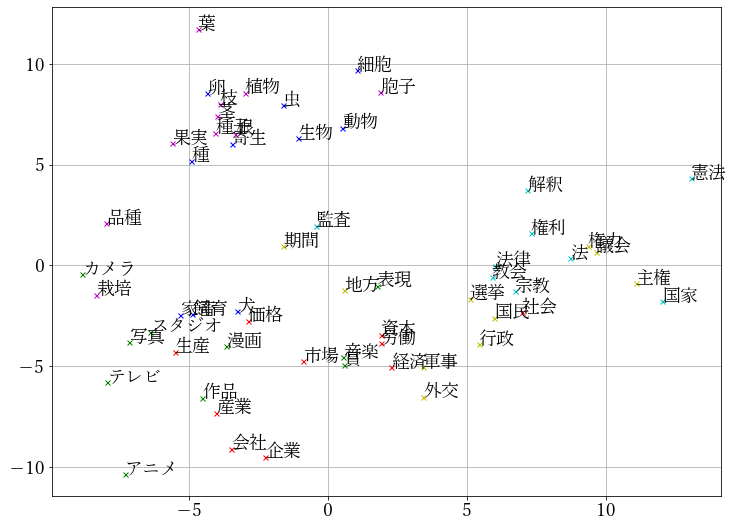

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

# IPAex日本語フォントのインストールができた人は、以下によって日本語が出力できるはずです
# できていない環境では、日本語の文字は□に置き換えられます
#plt.rcParams["font.family"] = "IPAexGothic"

# Windowsなら以下でうまく行くかもしれません
plt.rcParams["font.family"] = "Yu Mincho"
# Macなら以下でうまく行くかもしれません
# plt.rcParams['font.family'] = 'AppleGothic'
# Colaboratoryでは以下を指定してください
# plt.rcParams["font.family"] = "IPAGothic"

plt.rcParams["font.size"] = 18

plt.figure(figsize=(12,9))
num = 0
for word in words:
    plt.plot(data_pca[num][0], data_pca[num][1], ms=5.0, zorder=2, marker='x', color=words[word])
    plt.annotate(word, (data_pca[num][0], data_pca[num][1])) 
    num += 1
plt.grid()
plt.savefig('fig/Word2vec1.png') # 図を画像として保存